# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [16]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [18]:
!dir ..\\assignment1

 Volume in drive C is EPRUPETW1824
 Volume Serial Number is 4E55-CD70

 Directory of C:\Users\Ilya_Starikov\PycharmProjects\self-education\dlcourse_ai\assignments\assignment1

12/16/2019  12:42 PM    <DIR>          .
12/16/2019  12:42 PM    <DIR>          ..
12/11/2019  03:03 PM    <DIR>          .ipynb_checkpoints
12/11/2019  03:03 PM    <DIR>          data
11/26/2019  03:46 PM             2,259 dataset.py
11/26/2019  03:46 PM               139 download_data.sh
12/12/2019  05:58 PM             1,846 gradient_check.py
11/27/2019  05:11 PM           156,834 KNN.ipynb
11/27/2019  01:59 PM             5,704 knn.py
12/16/2019  12:42 PM            50,020 Linear classifier.ipynb
12/07/2019  11:00 AM             6,688 linear_classifer.py
11/27/2019  04:58 PM             1,530 metrics.py
11/26/2019  03:46 PM             1,093 README.md
11/26/2019  03:46 PM                26 requirements.txt
12/11/2019  03:03 PM    <DIR>          __pycache__
              10 File(s)        226,139 bytes
       

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
FOLDER = '..\\assignment1\\data'
train_X, train_y, test_X, test_y = load_svhn(FOLDER, max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [139]:
from layers import ReLULayer

In [6]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [7]:
test = np.array([1,2,3,4])

In [8]:
v = np.dot(test, 2)
v2 = np.sum(test)

In [140]:
from layers import FullyConnectedLayer

In [141]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
print('\n dW')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
print('\n dB')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!

 dW
Gradient check passed!

 dB
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [134]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for FC1_W


TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

In [12]:
from gradient_check import check_gradient

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [14]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for fc1_w
Gradient check passed!
Checking gradient for fc1_b
Gradient check passed!
Checking gradient for fc2_w
Gradient check passed!
Checking gradient for fc2_b
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [19]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [22]:
optim = {}
for name, param in model.params().items():
    optim[name] = 

{'FC1_W': <layers.Param at 0x1fe68277488>,
 'FC1_B': <layers.Param at 0x1fe682774c8>,
 'FC2_W': <layers.Param at 0x1fe68277a08>,
 'FC2_B': <layers.Param at 0x1fe68277e88>}

In [35]:
for n, p in model.params().items():
    print({n: p})

{'FC1_W': <layers.Param object at 0x000001FE021F2188>}
{'FC1_B': <layers.Param object at 0x000001FE021F2FC8>}
{'FC2_W': <layers.Param object at 0x000001FE021F2508>}
{'FC2_B': <layers.Param object at 0x000001FE021F25C8>}


In [55]:
1 % 3

1

In [284]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2, num_epochs=5)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss:2.302448, Train accuracy: 0.196667, val accuracy: 0.206000


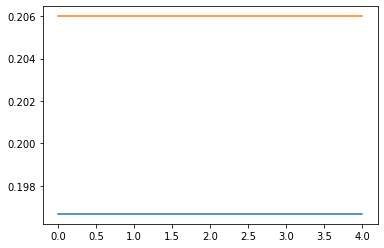

In [285]:
plt.plot(train_history)
plt.plot(val_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [115]:
initial_learning_rate

0.01

In [116]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99, num_epochs=5)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"


 EPOCH: 0
PREDICT STAGE
train predict 

PREDICTION
[ 597 1770 1334 1028  891  838  688  692  601  561]
[   0 9000]
val predict 

PREDICTION
[ 49 206 140 147  93  90  78  76  61  60]
[   0 1000]
Epoch: 0, Loss:2.268982, Train accuracy: 0.196667, val accuracy: 0.206000

 EPOCH: 1
PREDICT STAGE
train predict 

PREDICTION
[ 597 1770 1334 1028  891  838  688  692  601  561]
[   0 9000]
val predict 

PREDICTION
[ 49 206 140 147  93  90  78  76  61  60]
[   0 1000]
Epoch: 1, Loss:2.265676, Train accuracy: 0.196667, val accuracy: 0.206000

 EPOCH: 2
PREDICT STAGE
train predict 

PREDICTION
[ 597 1770 1334 1028  891  838  688  692  601  561]
[   0 9000]
val predict 

PREDICTION
[ 49 206 140 147  93  90  78  76  61  60]
[   0 1000]
Epoch: 2, Loss:2.265125, Train accuracy: 0.196667, val accuracy: 0.206000

 EPOCH: 3
PREDICT STAGE
train predict 

PREDICTION
[ 597 1770 1334 1028  891  838  688  692  601  561]
[   0 9000]
val predict 

PREDICTION
[ 49 206 140 147  93  90  78  76  61  60]
[   0 1000

In [117]:
from sklearn.preprocessing import normalize

In [119]:
train_X[:2].shape

(2, 3072)

In [120]:
import matplotlib.pyplot as plt
%matplotlib inline

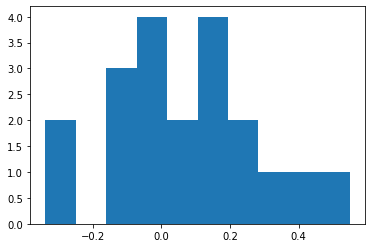

In [130]:
plt.hist(train_X[:20, 1]);

In [127]:
norm_x = normalize(train_X[:20], axis=0)

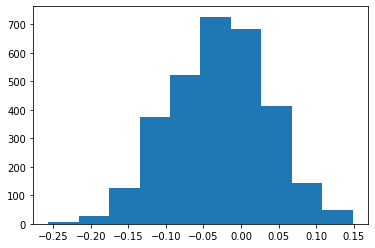

In [129]:
plt.hist(norm_x[1]);

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [180]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss:20.797530, Train accuracy: 0.171444, val accuracy: 0.175000
Epoch: 5, Loss:9.949386, Train accuracy: 0.207222, val accuracy: 0.210000
Epoch: 10, Loss:5.739296, Train accuracy: 0.203222, val accuracy: 0.208000
Epoch: 15, Loss:3.779118, Train accuracy: 0.197778, val accuracy: 0.206000


# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [176]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss:22.661903, Train accuracy: 0.733333, val accuracy: 0.000000
Epoch: 5, Loss:12.431909, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 10, Loss:7.495170, Train accuracy: 0.933333, val accuracy: 0.066667
Epoch: 15, Loss:4.585588, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 20, Loss:3.359785, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 25, Loss:2.247959, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 30, Loss:1.929583, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 35, Loss:1.800376, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 40, Loss:1.702572, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 45, Loss:1.584264, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 50, Loss:1.479005, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 55, Loss:1.326876, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 60, Loss:1.370120, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 65, Loss:1.386965,

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [179]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-2, num_epochs=20, batch_size=5)

loss_history, train_history, val_history = trainer.fit()

Epoch: 0, Loss:24.160133, Train accuracy: 0.400000, val accuracy: 0.266667
Epoch: 5, Loss:15.720726, Train accuracy: 0.933333, val accuracy: 0.000000
Epoch: 10, Loss:8.853191, Train accuracy: 1.000000, val accuracy: 0.000000
Epoch: 15, Loss:4.677766, Train accuracy: 1.000000, val accuracy: 0.000000


# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [260]:
x_test = np.array([[ 1,  2, -3,  0],
                   [ -2,  2, 0.5,  1],
                   [ 1,  1,  2,  0]])
x_test

array([[ 1. ,  2. , -3. ,  0. ],
       [-2. ,  2. ,  0.5,  1. ],
       [ 1. ,  1. ,  2. ,  0. ]])

In [261]:
np.mean((x_test - mean)**2, axis=0)+1e-7

array([3.0000001 , 0.2500001 , 4.5000001 , 0.33333343])

In [262]:
mean = np.mean(x_test, axis=0)  # shape == (X.shape[1], )
sig = np.sqrt(np.mean((x_test - mean)**2, axis=0)+1e-7)
out = (x_test - mean) / sig
out

array([[ 0.70710676,  0.70710662, -1.35244737, -0.70710662],
       [-1.41421353,  0.70710662,  0.31822291,  1.41421324],
       [ 0.70710676, -1.41421324,  1.03422446, -0.70710662]])

In [242]:
learning_rates = np.round(0.1**np.arange(1, 5), 8)
lr = np.random.choice(learning_rates)
lr

0.01

In [ ]:
# Let's train the best one-hidden-layer network we can

learning_rates = [0.01]
reg_strength = [0.001]  # np.round(0.1**np.arange(1, 5), 8)
learning_rate_decay = 0.999  # 0.5 # 0.999
hidden_layer_size = [100, 128]
num_epochs = 101
batch_size = [64]

# add batch_normalization
# add decy by epoch each 5 with lr/(1 + decay*epoch_n)  # do not work

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above


# for n in range(10):
    
for h in hidden_layer_size:
    print("\nSTART")
    lr = np.random.choice(learning_rates)
    reg = np.random.choice(reg_strength)
    batch = np.random.choice(batch_size)
    hidden_size = h  # np.random.choice(hidden_layer_size)
    print(f"PARAMS: lr - {lr}, reg_strenght - {reg}, batch size - {batch}, hidden_size - {hidden_size}")
    
    model = TwoLayerNet(n_input = train_X.shape[1], n_output=10, hidden_layer_size=hidden_size, reg=reg)
    dataset = Dataset(train_X, train_y, val_X, val_y)
    trainer = Trainer(model, dataset, MomentumSGD(),
                      batch_size=batch,
                      num_epochs=num_epochs, 
                      learning_rate=lr, 
                      learning_rate_decay=learning_rate_decay)

    loss, train, val = trainer.fit()
    
    if val[-1] > best_val_accuracy:
        print(f"\n NEW best val accuracy: {val[-1]} "
              f"PARAMS: lr - {lr}, reg_strenght - {reg}, batch size - {batch}, hidden_size - {hidden_size}")
        best_val_accuracy = val[-1]
        loss_history = loss
        train_history = train
        val_history = val
        best_classifier = model
        best_params = {'lr': lr,
                       'reg_strenght': reg,
                       'batch size': batch,
                       'hidden_size': hidden_size}
        
    print("END \n")
        

# best_val_accuracy = np.max(val)
print('best validation accuracy achieved: %f' % best_val_accuracy)
print(f"Best params: {best_params}")


START
PARAMS: lr - 0.01, reg_strenght - 0.001, batch size - 64, hidden_size - 100
Epoch: 0, Loss:2.019098, Train accuracy: 0.388556, val accuracy: 0.402000
Epoch: 5, Loss:1.278629, Train accuracy: 0.710889, val accuracy: 0.681000
Epoch: 10, Loss:1.007386, Train accuracy: 0.766889, val accuracy: 0.736000
Epoch: 15, Loss:1.146120, Train accuracy: 0.799444, val accuracy: 0.727000
Epoch: 20, Loss:0.900739, Train accuracy: 0.829556, val accuracy: 0.758000
Epoch: 25, Loss:0.825688, Train accuracy: 0.835889, val accuracy: 0.745000
Epoch: 30, Loss:0.753128, Train accuracy: 0.859222, val accuracy: 0.764000
Epoch: 35, Loss:0.653961, Train accuracy: 0.878222, val accuracy: 0.769000
Epoch: 40, Loss:0.813306, Train accuracy: 0.870222, val accuracy: 0.757000
Epoch: 45, Loss:0.705066, Train accuracy: 0.872889, val accuracy: 0.746000
Epoch: 50, Loss:0.909892, Train accuracy: 0.897444, val accuracy: 0.767000
Epoch: 55, Loss:0.705901, Train accuracy: 0.890000, val accuracy: 0.758000
Epoch: 60, Loss:0.5

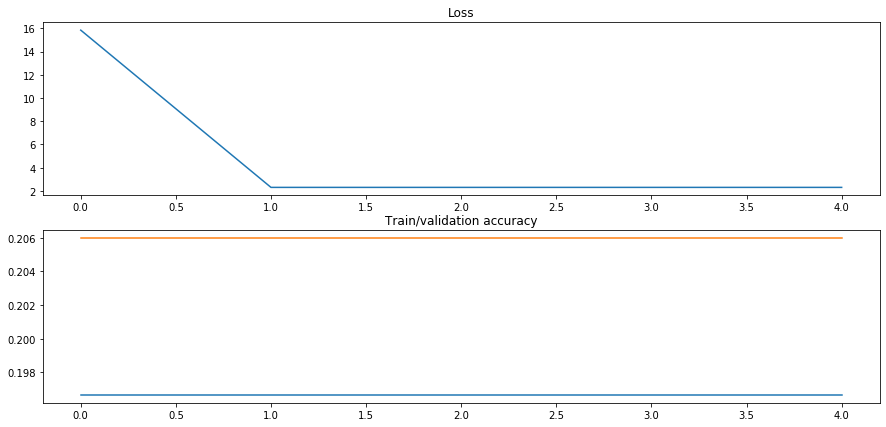

In [286]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history);

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [194]:
best_classifier = model
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.661000
